
parsed options:
{'dataroot': '/scratch/hb1500/Face_Aligned_6400/train_l/', 'testdataroot': '/scratch/hb1500/Face_Aligned_6670/test_l/', 'lfw_dir': '/scratch/hb1500/lfw/lfw', 'lfw_pairs_path': 'lfw_pairs.txt', 'log_dir': '/scratch/hb1500/logdir_triplet_loss', 'resume': '/scratch/hb1500/logdir_triplet_loss/run-optim_adam-lr0.001-wd0.0-embeddings512-center0.5-MSCeleb/checkpoint_11.pth', 'start_epoch': 0, 'epochs': 50, 'center_loss_weight': 0.5, 'alpha': 0.5, 'embedding_size': 512, 'batch_size': 64, 'test_batch_size': 64, 'n_triplets': 100, 'margin': 1.0, 'lr': 0.001, 'beta1': 0.5, 'lr_decay': 0.0001, 'wd': 0.0, 'optimizer': 'adam', 'no_cuda': False, 'gpu_id': '0', 'seed': 0, 'log_interval': 10, 'cuda': True}


Number of Classes:
6400

=> no checkpoint found at /scratch/hb1500/logdir_triplet_loss/run-optim_adam-lr0.001-wd0.0-embeddings512-center0.5-MSCeleb/checkpoint_11.pth


Train Epoch: 0 [0/100 (0%)]	Loss: 9.805496 	 # of Selected Triplets: 61: : 0it [00:03, ?it/s]

Train Epoch: 0 [0/100 (0%)]\tLoss: 9.805496\t# of Selected Triplets: 61 

Train set: Accuracy: 0.05833333






0it [00:00, ?it/s]
Test LFW Epoch: 0 [0/6000 (0%)]: : 0it [00:01, ?it/s]
Exception in thread Thread-7:
Traceback (most recent call last):
  File "/share/apps/python3/3.6.3/intel/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/tqdm-4.19.4-py3.6.egg/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/hb1500/py3.6.3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Test LFW set: Accuracy: 0.98333333




Test Epoch: 0 [0/12800 (0%)]	Test Recognition Prec@1 0.00 (0.00): : 1it [00:04,  4.12s/it]

Test Epoch: 0 [0/12800 (0%)]	Test Recognition Prec@1 0.00 (0.00) 




Test Epoch: 0 [0/12800 (0%)]	Test Recall@1  0.00 
Test Epoch: 0 [0/12800 (0%)]	Test Recall@1  0.00 
: : 1it [00:03,  3.84s/it]


Test Epoch: 0 [0/12800 (0%)]	Test Recall@1  0.00 

Distance: 1.595484972000122
Distance: 1.7155964374542236
Distance: 1.7788029909133911
Distance: 1.740069031715393
Distance: 1.7705122232437134
Distance (anchor-positive): 1.3249489068984985
Distance (anchor-negative): 1.527209758758545


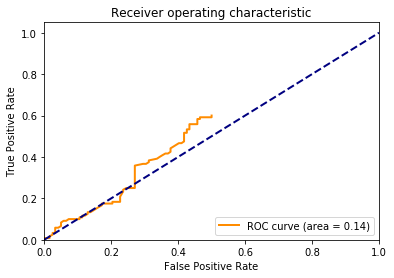

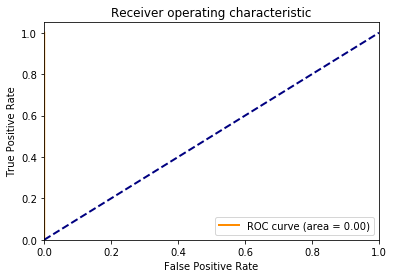

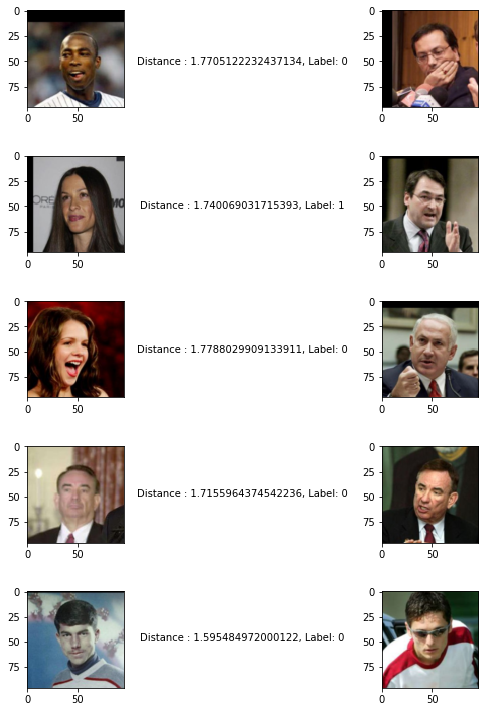

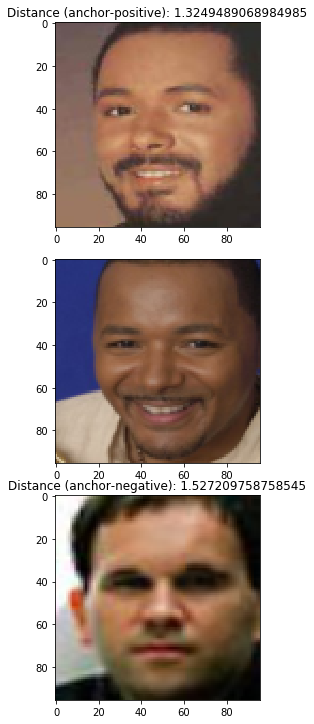

In [5]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torch.autograd import Function
import torch.backends.cudnn as cudnn
import os
import numpy as np
from tqdm import tqdm
from model import FaceModel,FaceModelCenter,FaceModelSoftmax
from eval_metrics import evaluate
from logger import Logger
from LFWDataset import LFWDataset
from TripletFaceDataset import TripletFaceDataset
from TrainDataset import TrainDataset
from PIL import Image
from utils import PairwiseDistance,display_triplet_distance,display_triplet_distance_test
import collections

# Training settings
parser = argparse.ArgumentParser(description='PyTorch Face Recognition')
# Model options
parser.add_argument('--dataroot', type=str, default='/scratch/hb1500/Face_Aligned_6400/train_l/',#default='/media/lior/LinuxHDD/datasets/vgg_face_dataset/aligned'
                    help='path to dataset')
parser.add_argument('--testdataroot', type=str, default='/scratch/hb1500/Face_Aligned_6670/test_l/',#default='/media/lior/LinuxHDD/datasets/vgg_face_dataset/aligned'
                    help='path to dataset')
parser.add_argument('--lfw-dir', type=str, default='/scratch/hb1500/lfw/lfw',
                    help='path to dataset')
parser.add_argument('--lfw-pairs-path', type=str, default='lfw_pairs.txt',
                    help='path to pairs file')

parser.add_argument('--log-dir', default='/scratch/hb1500/logdir_triplet_loss',
                    help='folder to output model checkpoints')

parser.add_argument('--resume',
                    default='/scratch/hb1500/logdir_triplet_loss/run-optim_adam-lr0.001-wd0.0-embeddings512-center0.5-MSCeleb/checkpoint_11.pth',
                    type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('--epochs', type=int, default=50, metavar='E',
                    help='number of epochs to train (default: 10)')
# Training options
# parser.add_argument('--embedding-size', type=int, default=256, metavar='ES',
#                     help='Dimensionality of the embedding')

parser.add_argument('--center_loss_weight', type=float, default=0.5, help='weight for center loss')
parser.add_argument('--alpha', type=float, default=0.5, help='learning rate of the centers')
parser.add_argument('--embedding-size', type=int, default=512, metavar='ES',
                    help='Dimensionality of the embedding')

parser.add_argument('--batch-size', type=int, default=64, metavar='BS',
                    help='input batch size for training (default: 128)')
parser.add_argument('--test-batch-size', type=int, default=64, metavar='BST',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--n-triplets', type=int, default=100, metavar='N',
                    help='how many triplets will generate from the dataset,default=1000000')
parser.add_argument('--margin', type=float, default=1.0, metavar='MARGIN',
                    help='the margin value for the triplet loss function (default: 1.0')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 0.001)')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')

parser.add_argument('--lr-decay', default=1e-4, type=float, metavar='LRD',
                    help='learning rate decay ratio (default: 1e-4')
parser.add_argument('--wd', default=0.0, type=float,
                    metavar='W', help='weight decay (default: 0.0)')
parser.add_argument('--optimizer', default='adam', type=str,
                    metavar='OPT', help='The optimizer to use (default: Adagrad)')
# Device options
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--gpu-id', default='0', type=str,
                    help='id(s) for CUDA_VISIBLE_DEVICES')
parser.add_argument('--seed', type=int, default=0, metavar='S',
                    help='random seed (default: 0)')
parser.add_argument('--log-interval', type=int, default=10, metavar='LI',
                    help='how many batches to wait before logging training status')

args = parser.parse_args(args = [])

# set the device to use by setting CUDA_VISIBLE_DEVICES env variable in
# order to prevent any memory allocation on unused GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu_id

args.cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)

if not os.path.exists(args.log_dir):
    os.makedirs(args.log_dir)

if args.cuda:
    cudnn.benchmark = True

#LOG_DIR = args.log_dir + '/run-optim_{}-lr{}-wd{}-embeddings{}-center_loss{}-MSCeleb'.format(args.optimizer, args.lr, args.wd,args.embedding_size,args.center_loss_weight)
LOG_DIR = args.log_dir + '/run-optim_{}-n{}-lr{}-wd{}-m{}-embeddings{}-msceleb-alpha10'\
    .format(args.optimizer, args.n_triplets, args.lr, args.wd,
            args.margin,args.embedding_size)

LOG_DIR_LOG = args.log_dir + '/logger'

# create logger
logger = Logger(LOG_DIR_LOG)


kwargs = {'num_workers': 2, 'pin_memory': True} if args.cuda else {}
l2_dist = PairwiseDistance(2)


transform = transforms.Compose([
                         transforms.Resize((96,96)),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(),
                         transforms.Normalize(mean = [ 0.5, 0.5, 0.5 ],
                                               std = [ 0.5, 0.5, 0.5 ])
                     ])

#train_dir = TripletFaceDataset(args.dataroot,transform=transform)
train_dir = TripletFaceDataset(dir=args.dataroot,n_triplets=args.n_triplets,transform=transform)
train_loader = torch.utils.data.DataLoader(train_dir,batch_size=args.batch_size, shuffle=False, **kwargs)
#testacc_dir = TripletFaceDataset(dir=args.dataroot,n_triplets=args.n_triplets,transform=transform)
#train_loader = torch.utils.data.DataLoader(train_dir,batch_size=args.batch_size, shuffle=True, **kwargs)

#testaccuracy_loader = torch.utils.data.DataLoader(testacc_dir,
#    batch_size=args.batch_size, shuffle=True, **kwargs)
testacc_dir = ImageFolder(args.testdataroot,transform=transform)
test_loader = torch.utils.data.DataLoader(
    LFWDataset(dir=args.lfw_dir,pairs_path=args.lfw_pairs_path,
                     transform=transform),
    batch_size=args.batch_size, shuffle=False, **kwargs)
testaccuracy_loader = torch.utils.data.DataLoader(testacc_dir,
    batch_size=args.batch_size, shuffle=True, **kwargs)


class TripletMarginLoss(Function):
    """Triplet loss function.
    """
    def __init__(self, margin):
        super(TripletMarginLoss, self).__init__()
        self.margin = margin
        self.pdist = PairwiseDistance(2)  # norm 2

    def forward(self, anchor, positive, negative):
        d_p = self.pdist.forward(anchor, positive)
        d_n = self.pdist.forward(anchor, negative)

        dist_hinge = torch.clamp(self.margin + d_p - d_n, min=0.0)
        loss = torch.mean(dist_hinge)
        return loss


    
    
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



def train(train_loader, model, optimizer, epoch):
    # switch to train mode
    model.train()

    pbar = tqdm(enumerate(train_loader))
    labels, distances = [], []


    for batch_idx, (data_a, data_p, data_n,label_p,label_n) in pbar:

        data_a, data_p, data_n = data_a.cuda(), data_p.cuda(), data_n.cuda()
        data_a, data_p, data_n = Variable(data_a), Variable(data_p), \
                                 Variable(data_n)

        # compute output
        out_a, out_p, out_n = model(data_a), model(data_p), model(data_n)

        # Choose the hard negatives
        d_p = l2_dist.forward(out_a, out_p)
        d_n = l2_dist.forward(out_a, out_n)
#        all = (d_n - d_p < args.margin).cpu().data.numpy().flatten()
        all_ = (d_n - d_p < args.margin).cpu().data.numpy().flatten()
        hard_triplets = np.where(all_ == 1)
        if len(hard_triplets[0]) == 0:
            continue
        out_selected_a = Variable(torch.from_numpy(out_a.cpu().data.numpy()[hard_triplets]).cuda())
        out_selected_p = Variable(torch.from_numpy(out_p.cpu().data.numpy()[hard_triplets]).cuda())
        out_selected_n = Variable(torch.from_numpy(out_n.cpu().data.numpy()[hard_triplets]).cuda())

        selected_data_a = Variable(torch.from_numpy(data_a.cpu().data.numpy()[hard_triplets]).cuda())
        selected_data_p = Variable(torch.from_numpy(data_p.cpu().data.numpy()[hard_triplets]).cuda())
        selected_data_n = Variable(torch.from_numpy(data_n.cpu().data.numpy()[hard_triplets]).cuda())

        selected_label_p = torch.from_numpy(label_p.cpu().numpy()[hard_triplets])
        selected_label_n= torch.from_numpy(label_n.cpu().numpy()[hard_triplets])
        triplet_loss = TripletMarginLoss(args.margin).forward(out_selected_a, out_selected_p, out_selected_n)

        cls_a = model.forward_classifier(selected_data_a)
        cls_p = model.forward_classifier(selected_data_p)
        cls_n = model.forward_classifier(selected_data_n)

        criterion = nn.CrossEntropyLoss()
        predicted_labels = torch.cat([cls_a,cls_p,cls_n])
        true_labels = torch.cat([Variable(selected_label_p.cuda()),Variable(selected_label_p.cuda()),Variable(selected_label_n.cuda())])

        cross_entropy_loss = criterion(predicted_labels.cuda(),true_labels.cuda())

        loss = cross_entropy_loss + triplet_loss
        # compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update the optimizer learning rate
        adjust_learning_rate(optimizer)

        # log loss value
        logger.log_value('triplet_loss', triplet_loss.data[0]).step()
        logger.log_value('cross_entropy_loss', cross_entropy_loss.data[0]).step()
        logger.log_value('total_loss', loss.data[0]).step()
        if batch_idx % args.log_interval == 0:
            pbar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \t # of Selected Triplets: {}'.format(
                    epoch, batch_idx * len(data_a), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.data[0],len(hard_triplets[0])))
#             file = open('./log_triplet_loss/Train_Accuracy.txt','a') 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\\tLoss: {:.6f}\\t# of Selected Triplets: {} \n'.format(
                    epoch, batch_idx * len(data_a), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.data[0],len(hard_triplets[0])))
#             file.close()


        dists = l2_dist.forward(out_selected_a,out_selected_n) #torch.sqrt(torch.sum((out_a - out_n) ** 2, 1))  # euclidean distance
        distances.append(dists.data.cpu().numpy())
        labels.append(np.zeros(dists.size(0)))


        dists = l2_dist.forward(out_selected_a,out_selected_p)#torch.sqrt(torch.sum((out_a - out_p) ** 2, 1))  # euclidean distance
        distances.append(dists.data.cpu().numpy())
        labels.append(np.ones(dists.size(0)))

        
        
    labels = np.array([sublabel for label in labels for sublabel in label])
    distances = np.array([subdist for dist in distances for subdist in dist])

    tpr, fpr, accuracy, val, val_std, far = evaluate(distances,labels)
    print('\33[91mTrain set: Accuracy: {:.8f}\n\33[0m'.format(np.mean(accuracy)))
    logger.log_value('Train Accuracy', np.mean(accuracy))   
    
    if not os.path.exists(LOG_DIR):
        os.mkdir(LOG_DIR)
    # do checkpointing
    torch.save({'epoch': epoch + 1, 'state_dict': model.state_dict()},
               '{}/checkpoint_{}.pth'.format(LOG_DIR, epoch))
    plot_roc(fpr,tpr,figure_name="roc_train_epoch_{}.png".format(epoch))
    


def test(test_loader, model, epoch):
    # switch to evaluate mode
    model.eval()

    labels, distances = [], []

    pbar = tqdm(enumerate(test_loader))
    for batch_idx, (data_a, data_p, label) in pbar:
        if args.cuda:
            data_a, data_p = data_a.cuda(), data_p.cuda()
        data_a, data_p, label = Variable(data_a, volatile=True), \
                                Variable(data_p, volatile=True), Variable(label)

        # compute output
        out_a, out_p = model(data_a), model(data_p)
        dists = l2_dist.forward(out_a,out_p)#torch.sqrt(torch.sum((out_a - out_p) ** 2, 1))  # euclidean distance
        distances.append(dists.data.cpu().numpy())
        labels.append(label.data.cpu().numpy())

        if batch_idx % args.log_interval == 0:
            pbar.set_description('Test LFW Epoch: {} [{}/{} ({:.0f}%)]'.format(
                epoch, batch_idx * len(data_a), len(test_loader.dataset),
                100. * batch_idx / len(test_loader)))

            
    #print(distances)
    labels = np.array([sublabel for label in labels for sublabel in label])
    distances = np.array([subdist for dist in distances for subdist in dist])

    tpr, fpr, accuracy, val, val_std, far = evaluate(distances,labels)
    print('\33[91mTest LFW set: Accuracy: {:.8f}\n\33[0m'.format(np.mean(accuracy)))
    logger.log_value('Test Verification Accuracy', np.mean(accuracy))
    plot_roc(fpr,tpr,figure_name="roc_test_epoch_{}.png".format(epoch))

def testaccuracy(test_loader,model,epoch):
    # switch to evaluate mode
    model.eval()
    pbar = tqdm(enumerate(test_loader))
    top1 = AverageMeter()
    for batch_idx, (data, label) in pbar:
        data_v = Variable(data.cuda())
        target_value = Variable(label)

        # compute output
        prediction = model.forward_classifier(data_v)
        prec = accuracy(prediction.data, label.cuda(), topk=(1,))
        top1.update(prec[0], data_v.size(0))
        #correct += accuracy(prediction.data, label.cuda(), topk=(1,))[0]*data_v.size(0)
        
        if batch_idx % args.log_interval == 0:
            pbar.set_description(
                'Test Epoch: {} [{}/{} ({:.0f}%)]\t'
                'Test Recognition Prec@1 {:.2f} ({:.2f})'.format(
                    epoch, batch_idx * len(data_v), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader),
                    float(top1.val[0]),float(top1.avg[0])))
#             file = open('./log_triplet_loss/Recognition_Accuracy.txt','a') 
            print('Test Epoch: {} [{}/{} ({:.0f}%)]\t'
                'Test Recognition Prec@1 {:.2f} ({:.2f}) \n'.format(
                    epoch, batch_idx * len(data_v), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader),
                    float(top1.val[0]),float(top1.avg[0])))
#             file.close()

    logger.log_value('Test batch Recognition Accuracy', float(top1.val[0]))            
    logger.log_value('Test total Recognition Accuracy', float(top1.avg[0]))


def testRecall(test_loader,model,epoch):
    # switch to evaluate mode
    model.eval()
    pbar = tqdm(enumerate(test_loader))
    top1 = AverageMeter()
    for batch_idx, (data, label) in pbar:
        data = Variable(data.cuda())
        # compute output
        out_data = model(data)
        distance_matrix = get_distance(out_data.cpu().data.numpy())
        labels = label.cpu().numpy()
        
        names = []
        accs = []
        
        for k in [1, 2, 4, 8, 16]:
            names.append('Recall@%d' % k)
            correct, cnt = 0.0, 0.0
            for i in range(len(data)):
                distance_matrix[i, i] = 1e10
                nns = np.argpartition(distance_matrix[i], k)[:k]
                if any(labels[i] == labels[nn] for nn in nns):
                    correct += 1
                cnt += 1
            accs.append(correct/cnt)
        
        #correct += accuracy(prediction.data, label.cuda(), topk=(1,))[0]*data_v.size(0)
        
        if batch_idx % args.log_interval == 0:
            pbar.set_description(
                'Test Epoch: {} [{}/{} ({:.0f}%)]\t'
                'Test Recall@1  {:.2f} \n'.format(
                    epoch, batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader),
                    float(accs[0])))
#             file = open('./log_triplet_loss/Recognition_Recall.txt','a') 
            print('Test Epoch: {} [{}/{} ({:.0f}%)]\t'
                'Test Recall@1  {:.2f} \n'.format(
                    epoch, batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader),
                    float(accs[0])))
#             file.close()
        
        if batch_idx % args.log_interval == 0:                  
            logger.log_value('Test Recall (l)', accs[0])
            logger.log_value('Test Recall (2)', accs[1])
            logger.log_value('Test Recall (4)', accs[2])
            logger.log_value('Test Recall (8)', accs[3])
            logger.log_value('Test Recall (16)', accs[4])

def get_distance(x):
    """Helper function for margin-based loss. Return a distance matrix given a matrix."""
    n = x.shape[0]
    square = np.sum(x ** 2,1,keepdims =True)
    distance_square = square + square.T - (2.0 * np.dot(x, x.T))
    # Adding identity to make sqrt work.
    return np.sqrt(distance_square + np.identity(n))

def plot_roc(fpr,tpr,figure_name="roc.png"):
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    roc_auc = auc(fpr, tpr)
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    fig.savefig(os.path.join(LOG_DIR,figure_name), dpi=fig.dpi)


def adjust_learning_rate(optimizer):
    """Updates the learning rate given the learning rate decay.
    The routine has been implemented according to the original Lua SGD optimizer
    """
    for group in optimizer.param_groups:
        if 'step' not in group:
            group['step'] = 0
        group['step'] += 1

        group['lr'] = args.lr / (1 + group['step'] * args.lr_decay)


def create_optimizer(model, new_lr):
    # setup optimizer
    if args.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=new_lr,
                              momentum=0.9, dampening=0.9,
                              weight_decay=args.wd)
    elif args.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=new_lr,
                               weight_decay=args.wd, betas=(args.beta1, 0.999))
    elif args.optimizer == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(),
                                  lr=new_lr,
                                  lr_decay=args.lr_decay,
                                  weight_decay=args.wd)
    return optimizer

def main():
    #test_display_triplet_distance= True
    '''
    why test_display_triplet_distance= True in center loss.py?????
    '''
    test_display_triplet_distance= True
    # print the experiment configuration
    print('\nparsed options:\n{}\n'.format(vars(args)))
    print('\nNumber of Classes:\n{}\n'.format(str(6400)))
    num_classes = 6400
    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print('=> loading checkpoint {}'.format(args.resume))
            checkpoint = torch.load(args.resume)
            args.start_epoch = checkpoint['epoch']
        else:
            checkpoint = None
            print('=> no checkpoint found at {}'.format(args.resume))
    #print(checkpoint)
    # instantiate model and initialize weights
    #model = FaceModelSoftmax(embedding_size=args.embedding_size,num_classes=len(train_dir.classes),checkpoint=checkpoint)
    model = FaceModelSoftmax(embedding_size=args.embedding_size,
                      num_classes=num_classes,checkpoint=checkpoint)
    if args.cuda:
        #print("you are using gpu")
        model.cuda()

    optimizer = create_optimizer(model, args.lr)
    
    start = args.start_epoch
    end = start + args.epochs
    for epoch in range(start, end):
        train(train_loader, model, optimizer, epoch)
        test(test_loader, model, epoch)
        testaccuracy(testaccuracy_loader, model, epoch)
        testRecall(testaccuracy_loader, model, epoch)
        if test_display_triplet_distance:
            display_triplet_distance_test(model,test_loader,LOG_DIR+"/test_{}".format(epoch))
            display_triplet_distance(model,train_loader,LOG_DIR+"/train_{}".format(epoch))
if __name__ == '__main__':
    main()